# ***XG-Boost Balanced***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import pickle  # For saving and loading the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
import optuna
from sklearn.ensemble import RandomForestClassifier

import os
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna
import joblib
import time
import numpy as np
pd.options.display.float_format = '{:.3f}'.format

/home/ssilvera/Escritorio/Proyectos/Modelo_pagos/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel("../Preprocessed data.xlsx")
#df.columns

[I 2025-02-06 16:31:42,456] A new study created in memory with name: no-name-357c0de8-f250-4ef0-8967-a73f06e8be4b


Distribución después de ADASYN:
 Estado
1    15216
2    15102
0    14985
Name: count, dtype: int64
Model not found. Training a new one...
Study not found. Creating a new one...


[I 2025-02-06 16:31:42,841] Trial 0 finished with value: 0.8536707686150076 and parameters: {'booster': 'gbtree', 'lambda': 1.0852606775261281e-06, 'alpha': 1.5408129222313177e-08, 'subsample': 0.5962369795003841, 'colsample_bytree': 0.579866908344521, 'max_depth': 9, 'learning_rate': 0.15733968237674828, 'num_boost_round': 84}. Best is trial 0 with value: 0.8536707686150076.
[I 2025-02-06 16:31:43,011] Trial 1 finished with value: 0.8466163246996001 and parameters: {'booster': 'gbtree', 'lambda': 0.18381449096662986, 'alpha': 3.064728773775099e-08, 'subsample': 0.808820642005982, 'colsample_bytree': 0.5855870466821504, 'max_depth': 6, 'learning_rate': 0.28222131793665783, 'num_boost_round': 111}. Best is trial 0 with value: 0.8536707686150076.
[I 2025-02-06 16:31:43,141] Trial 2 finished with value: 0.8435550870181733 and parameters: {'booster': 'gbtree', 'lambda': 8.707487758413914e-06, 'alpha': 0.005199482289587079, 'subsample': 0.7427552577434504, 'colsample_bytree': 0.769268211562

Study saved as ../Study/optuna_study_XG_Balanced.pkl
Number of finished trials: 100
Best trial:
  Value: 0.8602462745745036
  Params: 
    booster: dart
    lambda: 1.8110094139510232e-08
    alpha: 0.00020082226198781265
    subsample: 0.9648604711751162
    colsample_bytree: 0.7986078157755071
    max_depth: 10
    learning_rate: 0.020193957269985335
    num_boost_round: 87
Optimization time: 16.78 seconds
Model saved as ../Models/xg_model_balanced.pkl

Validation Metrics:
F1-Score (Validation): 0.8698
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3211
           1       0.75      0.71      0.73       970
           2       0.76      0.77      0.76       586

    accuracy                           0.87      4767
   macro avg       0.81      0.80      0.81      4767
weighted avg       0.87      0.87      0.87      4767



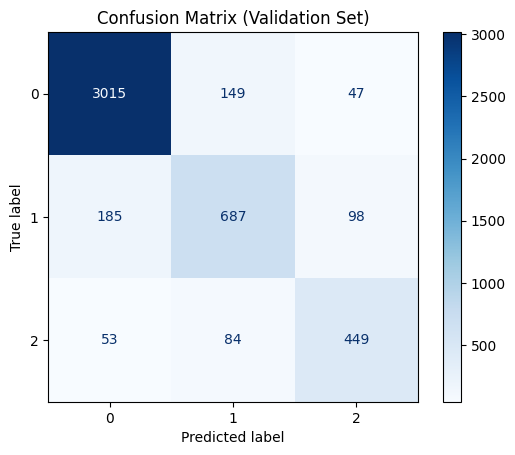

In [3]:
import os
import joblib
import xgboost as xgb
import pandas as pd
import optuna
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from imblearn.over_sampling import ADASYN

# Cargar el dataset
X = df.drop(columns=["Cuenta", "Estado"])
y = df["Estado"]

# Dividir en conjunto de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Aplicar ADASYN solo al conjunto de entrenamiento
adasyn = ADASYN(sampling_strategy="not majority", random_state=42, n_neighbors=10)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Verificar el balance de clases después de ADASYN
print("Distribución después de ADASYN:\n", pd.Series(y_train_resampled).value_counts())

# Definir nombres de archivos para guardar el modelo y el estudio de Optuna
model_filename = "../Models/xg_model_balanced.pkl"
study_filename = "../Study/optuna_study_XG_Balanced.pkl"

if os.path.exists(study_filename):
    print(f"Study found. Loading from {study_filename}...")
    study_xg_bal = joblib.load(study_filename)

# Verificar si el modelo ya existe
if os.path.exists(model_filename):
    print(f"Model found. Loading from {model_filename}...")
    xg_model = joblib.load(model_filename)
else:
    print("Model not found. Training a new one...")

    # Función objetivo para Optuna
    def objective(trial):
        param = {
            "verbosity": 0,
            "objective": "multi:softprob",
            "num_class": 3,
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_boost_round": trial.suggest_int("num_boost_round", 50, 150),
            "tree_method": "hist",
            "device": "cuda",
        }

        dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-mlogloss")
        model = xgb.train(param, dtrain, evals=[(dval, "validation")], callbacks=[pruning_callback], verbose_eval=False)

        y_val_pred = model.predict(dval)
        pred_labels = np.argmax(y_val_pred, axis=1)
        f1 = f1_score(y_val, pred_labels, average="weighted")
        return f1

    # Intentar cargar el estudio de Optuna si existe
    if os.path.exists(study_filename):
        print(f"Study found. Loading from {study_filename}...")
        study_xg_bal = joblib.load(study_filename)
    else:
        print("Study not found. Creating a new one...")
        pruner = optuna.pruners.MedianPruner() #n_warmup_steps=2
        study_xg_bal = optuna.create_study(direction="maximize", pruner=pruner)

        # Ejecutar la optimización solo si el estudio es nuevo
        start_time = time.time()
        study_xg_bal.optimize(objective, n_trials=100)
        end_time = time.time()

        # Guardar el estudio de Optuna
        joblib.dump(study_xg_bal, study_filename)
        print(f"Study saved as {study_filename}")

        print("Number of finished trials: {}".format(len(study_xg_bal.trials)))
        print("Best trial:")
        trial = study_xg_bal.best_trial

        print("  Value: {}".format(trial.value))
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))

        print(f"Optimization time: {end_time - start_time:.2f} seconds")

    # Obtener los mejores parámetros de la optimización
    best_params = study_xg_bal.best_params

    # Entrenar el modelo final con los mejores parámetros
    xg_model = xgb.XGBClassifier(**best_params, random_state=42)

    # Entrenar solo con el conjunto de entrenamiento balanceado
    xg_model.fit(X_train_resampled, y_train_resampled)

    # Guardar el modelo entrenado
    joblib.dump(xg_model, model_filename)
    print(f"Model saved as {model_filename}")

# Evaluación en el conjunto de validación
y_val_pred = xg_model.predict(X_val)

print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))

# Matriz de confusión en validación
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=xg_model.classes_)
disp_val.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


## ***Test Metrics***

In [4]:
# **Evaluación en el conjunto de prueba**
y_test_pred = xg_model.predict(X_test)

# Calcular F1-score, reporte de clasificación y matriz de confusión para `test`
f1_test = f1_score(y_test, y_test_pred, average="weighted")
print("\nTest Metrics:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))




Test Metrics:
F1-Score (Test): 0.8726
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      3212
           1       0.76      0.71      0.73       969
           2       0.73      0.76      0.74       586

    accuracy                           0.87      4767
   macro avg       0.81      0.81      0.81      4767
weighted avg       0.87      0.87      0.87      4767



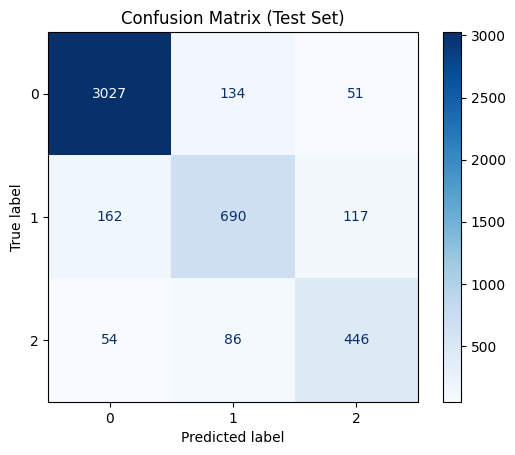

In [5]:
# Matriz de confusión para `test`
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=xg_model.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## ***Optuna Visualization***

In [6]:
optuna.visualization.plot_optimization_history(study_xg_bal)

In [7]:
optuna.visualization.plot_parallel_coordinate(study_xg_bal)

In [8]:
# Extract F1-scores from each trial in the study
f1_scores = [study_xg_bal.trials[i].value for i in range(len(study_xg_bal.trials))]  # Get the F1-score for each trial

# Create a plotly figure
fig = go.Figure()

# Add a line plot to the figure with the F1-scores
fig.add_trace(go.Scatter(
    x=list(range(len(study_xg_bal.trials))),  # X-axis: Trial number
    y=f1_scores,  # Y-axis: F1-score values
    mode='markers+lines',  # Display both markers and lines
    name='F1-score',  # Label for the line
    line=dict(color='blue'),  # Line color
    marker=dict(color='blue', size=6)  # Marker style
))

# Update layout for the plot
fig.update_layout(
    title="F1-Score Evolution During Optuna Optimization",  # Title of the plot
    xaxis_title="Trial",  # Label for X-axis
    yaxis_title="F1-Score",  # Label for Y-axis
    template="plotly_dark",  # Use dark template for better visibility
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [9]:
optuna.visualization.plot_slice(study_xg_bal, params=['booster', 'lambda', 'alpha', 'subsample', 'colsample_bytree', 'max_depth', 'learning_rate'])


In [10]:
optuna.visualization.plot_param_importances(study_xg_bal)

## ***Feature Importances***

In [11]:
# Extract feature importances from the trained model
importances = xg_model.feature_importances_

# Create a DataFrame for easier plotting
feature_names = X_train.columns  # Use the features from the final training set
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance and select the top 20
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importance using Plotly
fig = px.bar(importance_df, 
             x='Feature', 
             y='Importance', 
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',  # Color bars based on importance
             color_continuous_scale='Viridis',  # Use a color scale for better visualization
             text='Importance')  # Display importance values on the bars

# Rotate X-axis labels for better readability
fig.update_layout(xaxis_tickangle=45)

# Show the plot
fig.show()


In [12]:
importances_ = xg_model.feature_importances_
importances_

array([0.00757823, 0.00474121, 0.00523323, 0.00414811, 0.00417449,
       0.00435456, 0.01368713, 0.00742878, 0.03157849, 0.01771392,
       0.00869338, 0.00945009, 0.00596368, 0.01105043, 0.0048548 ,
       0.03399679, 0.00452931, 0.00405107, 0.00873262, 0.00684146,
       0.02715607, 0.02657318, 0.0053102 , 0.07833468, 0.09937616,
       0.01980934, 0.00659391, 0.00488701, 0.01390963, 0.01378162,
       0.04068056, 0.01779255, 0.01781392, 0.01205759, 0.01680307,
       0.01010994, 0.01008629, 0.01194505, 0.01744495, 0.02755992,
       0.01246066, 0.00229435, 0.00308888, 0.0037772 , 0.00271464,
       0.00579982, 0.00598487, 0.00500635, 0.00398926, 0.01010944,
       0.        , 0.00779769, 0.00509275, 0.00973146, 0.0035148 ,
       0.00477652, 0.00858758, 0.00590438, 0.00396116, 0.00564078,
       0.00491787, 0.0131241 , 0.00873533, 0.        , 0.01186731,
       0.02932192, 0.012253  , 0.00308383, 0.01195611, 0.00637079,
       0.0157472 , 0.00465588, 0.00508547, 0.02606281, 0.01579

In [13]:
# Extract feature importances from the trained model
importances_ = xg_model.feature_importances_

# Create a DataFrame for easier plotting
feature_names = X_train.columns  # Use the features from the final training set
importance_df_ = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_
})

importance_df_ = importance_df_.sort_values(by='Importance', ascending=False)
display(importance_df_.tail(20))

,Feature,Importance
27,antiguedad,0.005
14,PgMin,0.005
55,Arquetipos_05- Olvidadizo y Pagador,0.005
1,CONTEO_PRODUCTOS,0.005
71,CR_Mejor_Gestion_Cliente_Sin Gestion,0.005
16,Priorizacion,0.005
5,EDAD,0.004
4,DiasUltimaGestion,0.004
3,DiasMejorGestion,0.004
17,Priorizacion_mes_anterior,0.004


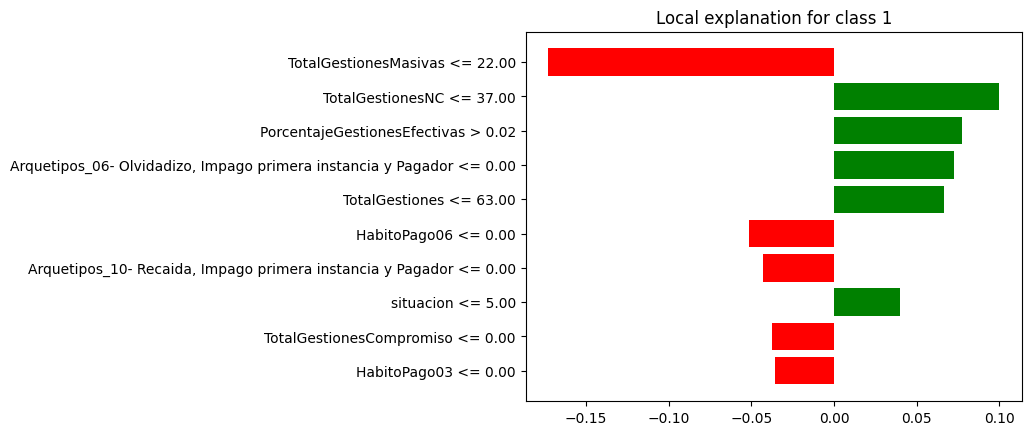

In [14]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,               # Training data (must be a numpy array or pandas dataframe)
    feature_names=X_train.columns,                    # Feature names (column names)
    class_names=y_train.unique(),                     # Target class names (unique classes in target column)
    mode='classification',                             # We're explaining a classification problem
    training_labels=y_train.values                     # Labels for training data
)

# Example 
i = 3
instance = X_test.iloc[i].values.reshape(1, -1)  # Reshape for LIME

exp = explainer.explain_instance(
    data_row=instance[0],                           # Instance to explain
    predict_fn=xg_model.predict_proba              # Model's predict function (predict_proba for probabilities)
)

# Show explanation in notebook (table of feature importances)
exp.show_in_notebook(show_table=True, show_all=False)

# Generate a plot for the explanation
fig = exp.as_pyplot_figure()
plt.show()

In [16]:
import graphviz

dot = xgb.to_graphviz(xg_model, num_trees=1)
dot.render("tree_xgb_bal")  # Guarda el gráfico en un archivo
dot  # Mostrar en Jupyter Notebook